# Loopless FBA

The goal of this procedure is identification of a thermodynamically consistent flux state without loops, as implied by the name. You can find a more detailed description in the [method](#Method) section at the end of the notebook.

In [1]:
%matplotlib inline
import plot_helper

from cobra.io import load_model
from cobra import Reaction, Metabolite, Model
from cobra.flux_analysis.loopless import add_loopless, loopless_solution
from cobra.flux_analysis import pfba

## Loopless solution

Classical loopless approaches as described below are computationally expensive to solve due to the added mixed-integer constraints. A much faster, and pragmatic approach is instead to post-process flux distributions to simply set fluxes to zero wherever they can be zero without changing the fluxes of any exchange reactions in the model. [CycleFreeFlux](http://dx.doi.org/10.1093/bioinformatics/btv096) is an algorithm that can be used to achieve this and in cobrapy it is implemented in the `cobra.flux_analysis.loopless_solution` function. `loopless_solution` will identify the closest flux distribution (using only loopless elementary flux modes) to the original one. Note that this will not remove loops which you explicitly requested, for instance by forcing a loop reaction to carry non-zero flux. 

Using a larger model than the simple example above, this can be demonstrated as follows

In [2]:
salmonella = load_model('salmonella')
nominal = salmonella.optimize()
loopless = loopless_solution(salmonella)

In [3]:
import pandas

df = pandas.DataFrame(dict(loopless=loopless.fluxes, nominal=nominal.fluxes))

<Axes: xlabel='loopless', ylabel='nominal'>

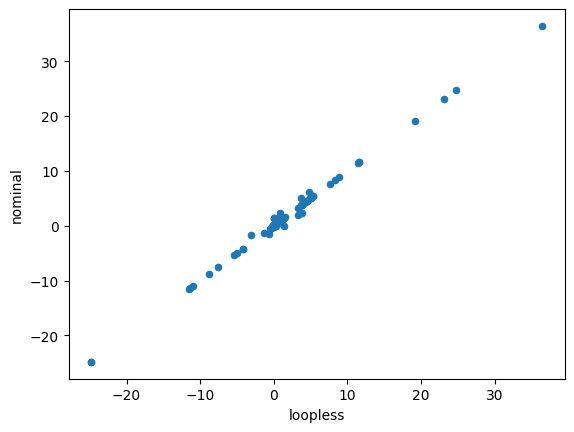

In [4]:
df.plot.scatter(x='loopless', y='nominal')

This functionality can also be used in FVA by using the `loopless=True` argument to avoid getting high flux ranges for reactions that essentially only can reach high fluxes if they are allowed to participate in loops (see the simulation notebook) leading to much narrower flux ranges.

## Loopless model

Cobrapy also includes the "classical" loopless formulation by [Schellenberger et. al.](https://dx.doi.org/10.1016%2Fj.bpj.2010.12.3707) implemented in `cobra.flux_analysis.add_loopless` modify the model with additional mixed-integer constraints that make thermodynamically infeasible loops impossible. This is much slower than the strategy provided above and should only be used if one of the two following cases applies:

1. You want to combine a non-linear (e.g. quadratic) objective with the loopless condition
2. You want to force the model to be infeasible in the presence of loops independent of the set reaction bounds.

We will demonstrate this with a toy model which has a simple loop cycling A $\rightarrow$ B $\rightarrow$ C $\rightarrow$ A, with A allowed to enter the system and C allowed to leave. A graphical view of the system is drawn below:

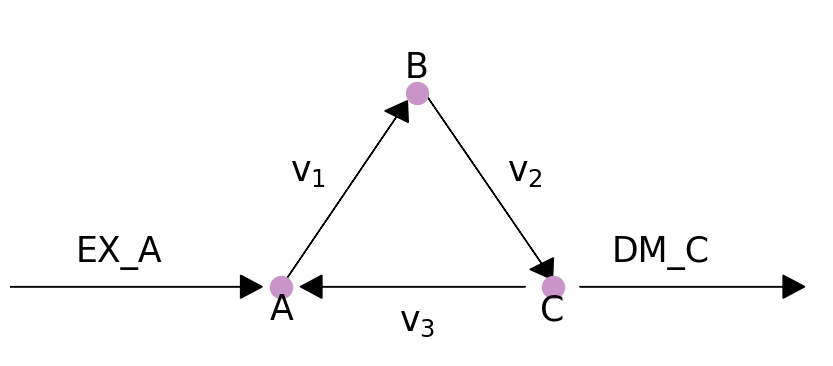

In [5]:
plot_helper.plot_loop()

In [6]:
model = Model()
model.add_metabolites([Metabolite(i) for i in "ABC"])
model.add_reactions([Reaction(i) for i in ["EX_A", "DM_C", "v1", "v2", "v3"]])

model.reactions.EX_A.add_metabolites({"A": 1})
model.reactions.DM_C.add_metabolites({"C": -1})

model.reactions.v1.add_metabolites({"A": -1, "B": 1})
model.reactions.v2.add_metabolites({"B": -1, "C": 1})
model.reactions.v3.add_metabolites({"C": -1, "A": 1})

model.objective = 'DM_C'

While this model contains a loop, a flux state exists which has no flux through reaction $v_3$, and is identified by loopless FBA.

In [7]:
with model:
    add_loopless(model)
    solution = model.optimize()
print("loopless solution: status = " + solution.status)
print("loopless solution flux: v3 = %.1f" % solution.fluxes["v3"])

loopless solution: status = optimal
loopless solution flux: v3 = 0.0


If there is no forced flux through a loopless reaction, parsimonious FBA will also have no flux through the loop.

In [8]:
solution = pfba(model)
print("parsimonious solution: status = " + solution.status)
print("loopless solution flux: v3 = %.1f" % solution.fluxes["v3"])

parsimonious solution: status = optimal
loopless solution flux: v3 = 0.0


However, if flux is forced through $v_3$, then there is no longer a feasible loopless solution, but the parsimonious solution will still exist.

In [9]:
model.reactions.v3.lower_bound = 1
with model:
    add_loopless(model)
    try:
        solution = model.optimize()
    except:
        print('model is infeasible')

model is infeasible


/home/cdiener/code/cobrapy/src/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


In [10]:
solution = pfba(model)
print("parsimonious solution: status = " + solution.status)
print("loopless solution flux: v3 = %.1f" % solution.fluxes["v3"])

parsimonious solution: status = optimal
loopless solution flux: v3 = 1.0


## Method

`loopless_solution` is based on a given reference flux distribution. It will look for a new flux distribution with the following requirements:

1. The objective value is the same as in the reference fluxes.
2. All exchange fluxes have the same value as in the reference distribution.
3. All non-exchange fluxes have the same sign (flow in the same direction) as the reference fluxes.
4. The sum of absolute non-exchange fluxes is minimized.

As proven in the [original publication](http://dx.doi.org/10.1093/bioinformatics/btv096) this will identify the "least-loopy" solution closest to the reference fluxes.

If you are using `add_loopless` this will use the method [described here](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3030201/). In summary, it will add $G \approx \Delta G$ proxy variables and make loops thermodynamically infeasible. This is achieved by the following formulation.

$$
\begin{aligned}
&\text{maximize } v_{obj} \\
s.t. & Sv = 0\\
& lb_j \leq v_j \leq ub_j \\
& -M\cdot (1 - a_i) \leq v_i \leq M\cdot a_i\\
& -1000a_i + (1 - a_i) \leq G_i \leq -a_i + 1000(1 - a_i)\\
& N_{int}G = 0\\
& a_i \in \{0, 1\}
\end{aligned}
$$

Here the index j runs over all reactions and the index i only over internal ones. $a_i$ are indicator variables which equal one if the reaction flux flows in hte forward direction and 0 otherwise. They are used to force the G proxies to always carry the opposite sign of the flux (as it is the case for the "real" $\Delta G$ values). $N_{int}$ is the nullspace matrix for internal reactions and is used to find thermodinamically "correct" values for G. 
